# EEGNet Model for Decoding EEG signal
### Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
if os.getcwd() == "/content":
  os.chdir("drive/MyDrive/EEGNet_Jinny/Code")

Mounted at /content/drive


In [ ]:
from EEGNet import *
from preprocessing import *
from filters import *

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from tqdm import tqdm
from tempfile import TemporaryDirectory
import os


Using cuda


In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# device = torch.device('cpu')
print("Using", device)

Using cuda


In [ ]:
class EEGNet(nn.Module):
    def __init__(self, T):
        super(EEGNet, self).__init__()

        # Declare fixed parameters for EEGNet
        C = 22 #number of channels
#         T = 1000 #number of time points
        F1 = 4 #number of temporal filters
        D = 2 #depth multiplier
        F2 = 16 #number of pointwise filters
        kernel_len = 64
        dropout_rate = 0.25

        # First block: Conv2D - BN - DWConv2D - BN - ELU - AvgPool - Dropout
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(1, F1, kernel_size=(1, kernel_len), bias=False, padding='same'),
            nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F1*D, kernel_size=(C, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1*D),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,4)),
            nn.Dropout(dropout_rate)
        )

        # Second block: SeparableConv2D - BN - ELU - AvgPool - Dropout
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(F1*D, F2, kernel_size=(1,16), padding='same', bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,8)),
            nn.Dropout(dropout_rate)
        )

        # Flatten
        self.flatten = nn.Flatten()

        # Dense
        self.dense = nn.Linear(F2*(T//32), 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x

### Implement Trainer-Tester Functions

In [ ]:
epochs = 500

def trainer(model, train_dataset, valid_dataset, bsz=50, epochs=500, optimizer='Adam'):
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bsz, shuffle=True)
        val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=bsz, shuffle=True)

        cel_loss = nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        history = {
            'train_acc':[],
            'val_acc':[],
            'train_loss':[],
            'val_loss':[],
        }
        best_train = 0.
        best_val = 0.
        best_train_loss = 10000000
        best_val_loss = 10000000

        pbar = range(epochs)
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

        for epoch in pbar:
            model.train()
            train_count = 0
            train_correct_count = 0
            for i, (x_, y_) in enumerate(train_loader):

                x_ = x_.float().to(device)
                y_ = y_.long().to(device)

                optimizer.zero_grad()
                logits = model(x_)
                loss = cel_loss(logits, y_)
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    y_hat = torch.argmax(logits, dim=-1)
                    train_correct_count += torch.sum(y_hat == y_, axis=-1)
                    train_count += x_.shape[0]
            train_acc = train_correct_count / train_count

            if train_acc > best_train:
                best_train = train_acc
            if loss < best_train_loss:
                best_train_loss = loss

            model.eval()
            val_count = 0
            val_correct_count = 0

            with torch.no_grad():
                for idx, (x_, y_) in enumerate(val_loader):
                    x_ = x_.float().to(device)
                    y_ = y_.long().to(device)
                    logits = model(x_).detach()
                    val_loss = cel_loss(logits, y_)

                    y_hat = torch.argmax(logits, dim=-1)
                    val_correct_count += torch.sum(y_hat == y_, axis=-1)
                    val_count += x_.shape[0]

                val_acc = val_correct_count / val_count

            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['train_loss'].append(loss.item())
            history['val_loss'].append(val_loss.item())

            if val_acc > best_val:
                best_val = val_acc
                torch.save(model.state_dict(), best_model_params_path)
            if val_loss < best_val_loss:
              best_val_loss = val_loss

            pbar.set_description((f'Epoch {epoch}, train acc = {train_acc:.4f}, val acc = {val_acc:.4f}'))

        print('Best train Accuracy: {:.3f}'.format(best_train))
        print('Best validation Accuracy: {:.3f}'.format(best_val))
        print('Best train Loss: {:.3f}'.format(best_train_loss))
        print('Best validation Loss: {:.3f}'.format(best_val_loss))

        model.load_state_dict(torch.load(best_model_params_path))

    return history, model

def tester(model, test_dataset):
    test_loader = torch.utils.data.DataLoader(test_dataset)

    model.eval()
    test_count = 0
    test_correct_count = 0

    with torch.no_grad():
        for idx, (x_, y_) in enumerate(test_loader):

            x_ = x_.float().to(device)
            y_ = y_.long().to(device)
            logits = model(x_).detach()
            y_hat = torch.argmax(logits, dim=-1)
            test_correct_count += torch.sum(y_hat == y_, axis=-1)
            test_count += x_.shape[0]
        test_acc = test_correct_count / test_count

    print('Test acc: {:.3f}'.format(test_acc))

### Part1: Training and validating model on raw EEG data
#### 1.1 Import raw data and load EEGNet model

In [ ]:
# Loading training data
person_train_valid = np.load("../Data/person_train_valid.npy")
X_train_valid = np.load("../Data/X_train_valid.npy")
y_train_valid = np.load("../Data/y_train_valid.npy")
y_train_valid -= 769

# Loading test data
person_test = np.load("../Data/person_test.npy")
X_test = np.load("../Data/X_test.npy")
y_test = np.load("../Data/y_test.npy")
y_test -= 769

# Print shape
print ('Shape of original training/valid data: {}'.format(X_train_valid.shape))
print ('Shape of original test data: {}'.format(X_test.shape))
print ('Shape of original oraining/Valid target: {}'.format(y_train_valid.shape))
print ('Shape of original test target: {}'.format(y_test.shape))
print ('Shape of original person train/valid: {}'.format(person_train_valid.shape))
print ('Shape of original person test: {}'.format(person_test.shape))

# Randomly split training-validation dataset
inx_valid = np.random.choice(2115, 423, replace=False)
inx_train = np.array(list(set(range(2115)).difference(set(inx_valid))))

(x_train, x_valid) = X_train_valid[inx_train], X_train_valid[inx_valid]
(y_train, y_valid) = y_train_valid[inx_train], y_train_valid[inx_valid]

print('Shape of training set after splitting:',x_train.shape)
print('Shape of validation set after splitting:',x_valid.shape)
print('Shape of training labels after splitting:',y_train.shape)
print('Shape of validation labels after splitting:',y_valid.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
x_valid = x_valid.reshape(x_valid.shape[0], 1, x_valid.shape[1], x_valid.shape[2])
x_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

# Convert to Tensor
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
valid_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

Shape of original training/valid data: (2115, 22, 1000)
Shape of original test data: (443, 22, 1000)
Shape of original oraining/Valid target: (2115,)
Shape of original test target: (443,)
Shape of original person train/valid: (2115, 1)
Shape of original person test: (443, 1)
Shape of training set after splitting: (1692, 22, 1000)
Shape of validation set after splitting: (423, 22, 1000)
Shape of training labels after splitting: (1692,)
Shape of validation labels after splitting: (423,)
Shape of training set after adding width info: (1692, 1, 22, 1000)
Shape of validation set after adding width info: (423, 1, 22, 1000)
Shape of test set after adding width info: (443, 1, 22, 1000)


#### 1.2 Train-Validate-Test model on raw data

In [ ]:
model = EEGNet(T=x_train.shape[-1])
print(model.to(device))

EEGNet(
  (ConvLayer1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 64), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(4, 8, kernel_size=(22, 1), stride=(1, 1), groups=4, bias=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (6): Dropout(p=0.25, inplace=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=496, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)


#### 1.2 Train and validate EEGNet model

In [ ]:
# Train and validate model
EEGNet_history, model_raw = trainer(model, train_dataset, valid_dataset, epochs=epochs)

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 499, train acc = 0.8593, val acc = 0.6619: 100%|██████████| 500/500 [02:43<00:00,  3.06it/s]

Best train Accuracy: 0.879
Best validation Accuracy: 0.676
Best train Loss: 0.786
Best validation Loss: 0.871


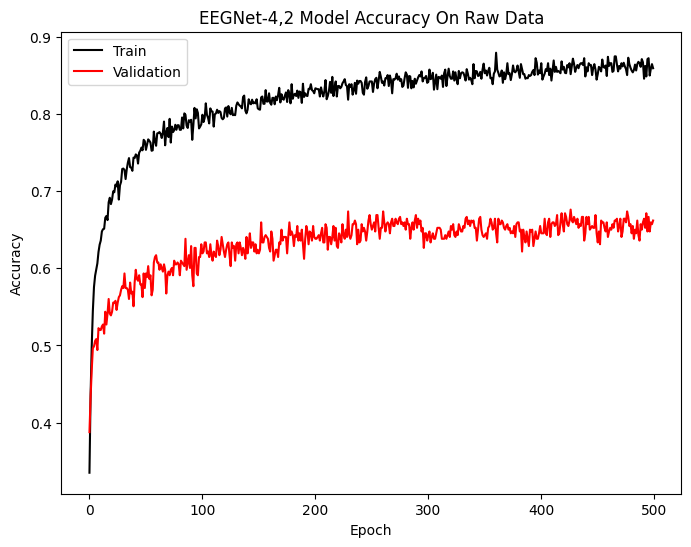

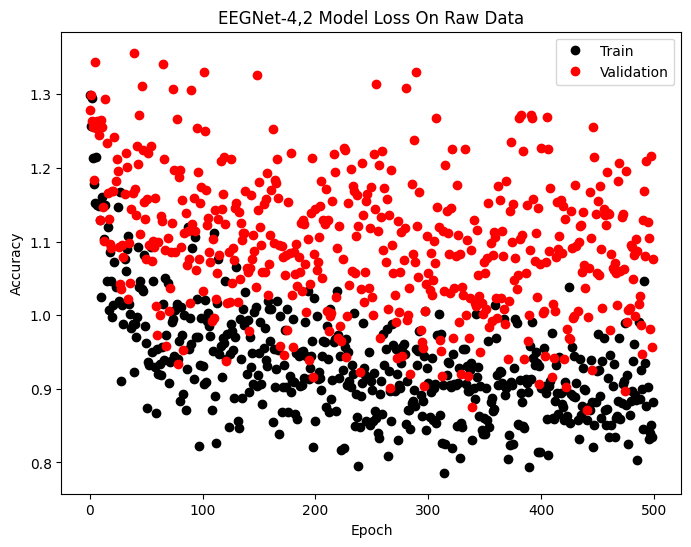

In [ ]:
plt.plot(torch.tensor(EEGNet_history['train_acc']).cpu(), label='Train', color='black')
plt.plot(torch.tensor(EEGNet_history['val_acc']).cpu(), label='Validation', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EEGNet-4,2 Model Accuracy On Raw Data')
plt.savefig('EEGNet-4,2 Model Accuracy On Raw Data.png', bbox_inches='tight', dpi=150)
plt.show()

plt.plot(EEGNet_history['train_loss'],'o', label='Train', color='black')
plt.plot(EEGNet_history['val_loss'],'o', label='Validation', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EEGNet-4,2 Model Loss On Raw Data')
plt.savefig('EEGNet-4,2 Model Loss On Raw Data.png', bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
tester(model_raw, test_dataset)

Test acc: 0.675


### Part2: Training and validating EEGNet model on EEG signal with data augmentation
#### 2.1 Perform data augmentation

In [ ]:
# Randomly split training-validation dataset
inx_valid = np.random.choice(2115, 423, replace=False)
inx_train = np.array(list(set(range(2115)).difference(set(inx_valid))))

(x_train, x_valid) = X_train_valid[inx_train], X_train_valid[inx_valid]
(y_train, y_valid) = y_train_valid[inx_train], y_train_valid[inx_valid]

print('Shape of training set after splitting:',x_train.shape)
print('Shape of validation set after splitting:',x_valid.shape)
print('Shape of training labels after splitting:',y_train.shape)
print('Shape of validation labels after splitting:',y_valid.shape,'\n')

# Preprocessing the dataset, may need to reload data at top
# pass only training data to train prep, val and test data to test prep
x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(X_test), test_data_prep(x_valid)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of test sets:', x_test.shape,'\n')

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
x_valid = x_valid.reshape(x_valid.shape[0], 1, x_valid.shape[1], x_valid.shape[2])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape,'\n')

# Convert to Tensor
train_aug_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
valid_aug_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))
test_aug_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

Shape of training set after splitting: (1692, 22, 1000)
Shape of validation set after splitting: (423, 22, 1000)
Shape of training labels after splitting: (1692,)
Shape of validation labels after splitting: (423,) 

Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: (6768, 22, 400)
Shape of validation set: (423, 22, 400)
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of test sets: (443, 22, 400) 

Shape of training set after adding width info: (6768, 1, 22, 400)
Shape of validation set after adding width info: (423, 1, 22, 400)
Shape of test set after adding width info: (443, 1, 22

#### 2.2 Train-Validate-Test model with data augmentation

In [ ]:
# Train and validate model
model = EEGNet(T=x_train.shape[-1]).to(device)
EEGNet_aug_history, model_aug = trainer(model, train_aug_dataset, valid_aug_dataset, epochs=epochs)

Epoch 499, train acc = 0.8453, val acc = 0.6950: 100%|██████████| 500/500 [05:32<00:00,  1.50it/s]

Best train Accuracy: 0.853
Best validation Accuracy: 0.745
Best train Loss: 0.745
Best validation Loss: 0.778


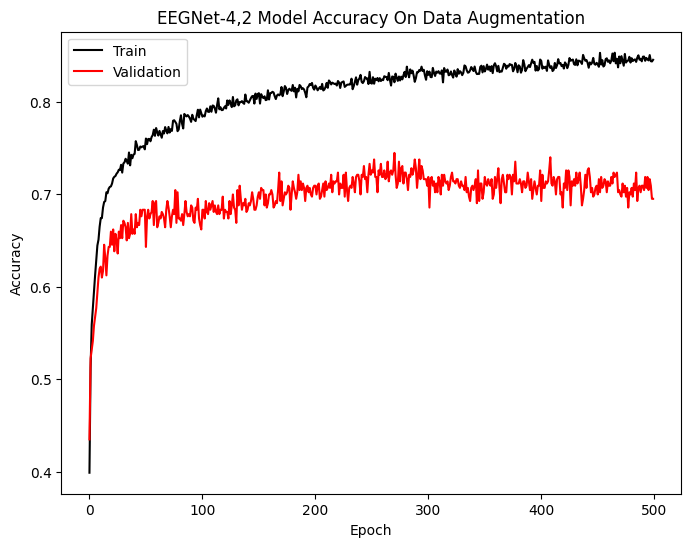

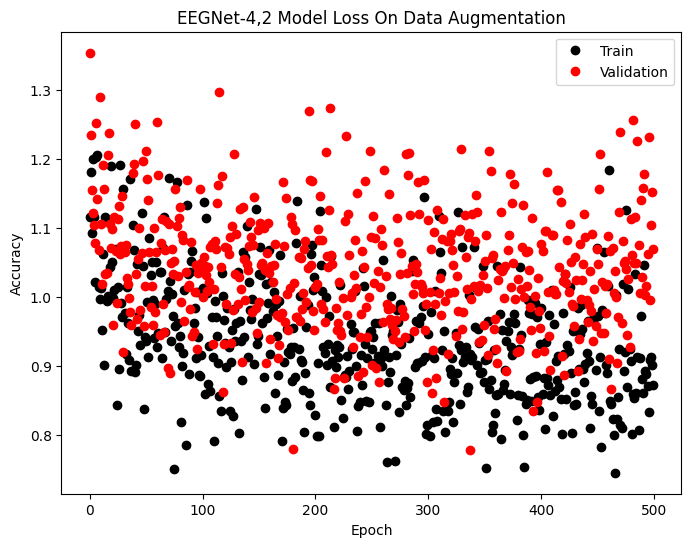

In [ ]:
plt.plot(torch.tensor(EEGNet_aug_history['train_acc']).cpu(), label='Train', color='black')
plt.plot(torch.tensor(EEGNet_aug_history['val_acc']).cpu(), label='Validation', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EEGNet-4,2 Model Accuracy On Data Augmentation')
plt.savefig('EEGNet-4,2 Model Accuracy On Data Augmentation.png', bbox_inches='tight', dpi=150)
plt.show()

plt.plot(torch.tensor(EEGNet_aug_history['train_loss']),'o', label='Train', color='black')
plt.plot(torch.tensor(EEGNet_aug_history['val_loss']),'o', label='Validation', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EEGNet-4,2 Model Loss On Data Augmentation')
plt.savefig('EEGNet-4,2 Model Loss On Data Augmentation.png', bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
tester(model_aug, test_aug_dataset)

Test acc: 0.707


### Part3: Perform low pass filter
#### 3.1 Perform low pass filter

In [ ]:
# Randomly split training-validation dataset
inx_valid = np.random.choice(2115, 423, replace=False)
inx_train = np.array(list(set(range(2115)).difference(set(inx_valid))))

(x_train, x_valid) = X_train_valid[inx_train], X_train_valid[inx_valid]
(y_train, y_valid) = y_train_valid[inx_train], y_train_valid[inx_valid]

print('Shape of training set after splitting:',x_train.shape)
print('Shape of validation set after splitting:',x_valid.shape)
print('Shape of training labels after splitting:',y_train.shape)
print('Shape of validation labels after splitting:',y_valid.shape,'\n')

# Preprocessing the dataset, may need to reload data at top
# pass only training data to train prep, val and test data to test prep
x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(X_test), test_data_prep(x_valid)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape,'\n')

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
x_valid = x_valid.reshape(x_valid.shape[0], 1, x_valid.shape[1], x_valid.shape[2])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape,'\n')

# Perform Low-pass Filter
x_train_lp = low_pass(x_train)
x_valid_lp = low_pass(x_valid)
x_test_lp = low_pass(x_test)

print('Shape of training set after low pass filter:',x_train_lp.shape)
print('Shape of validation set after low pass filter:',x_valid_lp.shape)
print('Shape of test set after low pass filter:',x_test_lp.shape)

# Convert to Tensor
train_lp_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_lp), torch.from_numpy(y_train))
valid_lp_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_valid_lp), torch.from_numpy(y_valid))
test_lp_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_lp), torch.from_numpy(y_test))

Shape of training set after splitting: (1692, 22, 1000)
Shape of validation set after splitting: (423, 22, 1000)
Shape of training labels after splitting: (1692,)
Shape of validation labels after splitting: (423,) 

Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: (6768, 22, 400)
Shape of validation set: (423, 22, 400)
Shape of training labels: (6768,)
Shape of validation labels: (423,) 

Shape of training set after adding width info: (6768, 1, 22, 400)
Shape of validation set after adding width info: (423, 1, 22, 400)
Shape of test set after adding width info: (443, 1, 22, 400) 

Shape of training set afte

#### 3.2 Train-Validate-Test model with low-pass filter

In [ ]:
# Train and validate model
model = EEGNet(x_train_lp.shape[-1]).to(device)
EEGNet_lp_history, model_lp = trainer(model, train_lp_dataset, valid_lp_dataset, epochs=epochs)

Epoch 499, train acc = 0.8568, val acc = 0.6832: 100%|██████████| 500/500 [05:30<00:00,  1.51it/s]

Best train Accuracy: 0.859
Best validation Accuracy: 0.707
Best train Loss: 0.746
Best validation Loss: 0.849


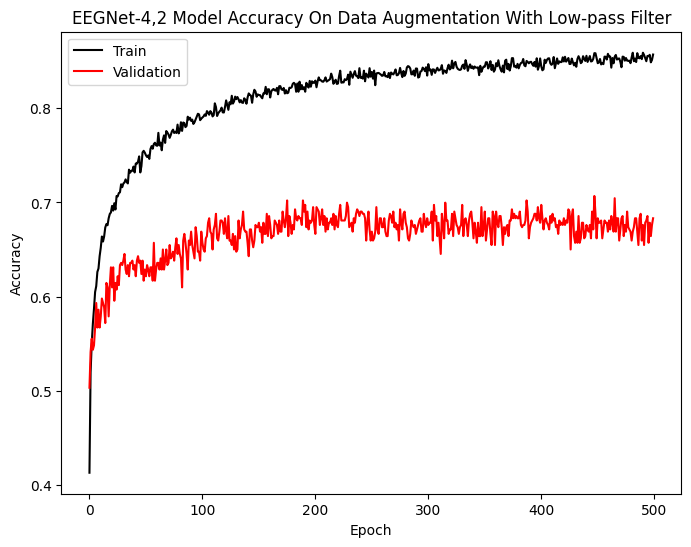

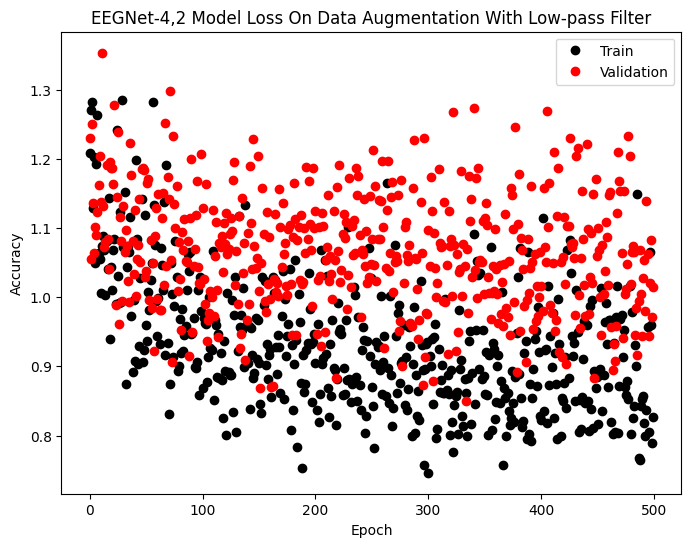

In [ ]:
plt.plot(torch.tensor(EEGNet_lp_history['train_acc']).cpu(), label='Train', color='black')
plt.plot(torch.tensor(EEGNet_lp_history['val_acc']).cpu(), label='Validation', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EEGNet-4,2 Model Accuracy On Data Augmentation With Low-pass Filter')
plt.savefig('EEGNet-4,2 Model Accuracy On Data Augmentation With Low-pass Filter.png', bbox_inches='tight', dpi=150)
plt.show()

plt.plot(torch.tensor(EEGNet_lp_history['train_loss']),'o', label='Train', color='black')
plt.plot(torch.tensor(EEGNet_lp_history['val_loss']),'o', label='Validation', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EEGNet-4,2 Model Loss On Data Augmentation With Low-pass Filter')
plt.savefig('EEGNet-4,2 Model Loss On Data Augmentation With Low-pass Filter.png', bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
tester(model_lp, test_lp_dataset)

Test acc: 0.682


### Part4: High-pass Filter
#### 4.1 Perform high-pass filter

In [ ]:
# Randomly split training-validation dataset
inx_valid = np.random.choice(2115, 423, replace=False)
inx_train = np.array(list(set(range(2115)).difference(set(inx_valid))))

(x_train, x_valid) = X_train_valid[inx_train], X_train_valid[inx_valid]
(y_train, y_valid) = y_train_valid[inx_train], y_train_valid[inx_valid]

print('Shape of training set after splitting:',x_train.shape)
print('Shape of validation set after splitting:',x_valid.shape)
print('Shape of training labels after splitting:',y_train.shape)
print('Shape of validation labels after splitting:',y_valid.shape,'\n')

# Preprocessing the dataset, may need to reload data at top
# pass only training data to train prep, val and test data to test prep
x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(X_test), test_data_prep(x_valid)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape,'\n')

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
x_valid = x_valid.reshape(x_valid.shape[0], 1, x_valid.shape[1], x_valid.shape[2])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape,'\n')

# Perform high-pass filter
x_train_hp = high_pass(x_train)
x_valid_hp = high_pass(x_valid)
x_test_hp = high_pass(x_test)

print('Shape of training set after low pass filter:',x_train_hp.shape)
print('Shape of validation set after low pass filter:',x_valid_hp.shape)
print('Shape of test set after low pass filter:',x_test_hp.shape)

# Convert to Tensor
train_hp_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_hp), torch.from_numpy(y_train))
valid_hp_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_valid_hp), torch.from_numpy(y_valid))
test_hp_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_hp), torch.from_numpy(y_test))

Shape of training set after splitting: (1692, 22, 1000)
Shape of validation set after splitting: (423, 22, 1000)
Shape of training labels after splitting: (1692,)
Shape of validation labels after splitting: (423,) 

Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: (6768, 22, 400)
Shape of validation set: (423, 22, 400)
Shape of training labels: (6768,)
Shape of validation labels: (423,) 

Shape of training set after adding width info: (6768, 1, 22, 400)
Shape of validation set after adding width info: (423, 1, 22, 400)
Shape of test set after adding width info: (443, 1, 22, 400) 

Shape of training set afte

#### 4.2 Train-Validate-Test model with high-pass filter

In [ ]:
# Train and validate model
model = EEGNet(x_train_hp.shape[-1]).to(device)
EEGNet_hp_history, model_hp = trainer(model,train_hp_dataset,valid_hp_dataset, epochs=epochs)

Epoch 499, train acc = 0.7702, val acc = 0.5603: 100%|██████████| 500/500 [06:10<00:00,  1.35it/s]

Best train Accuracy: 0.788
Best validation Accuracy: 0.615
Best train Loss: 0.778
Best validation Loss: 0.843


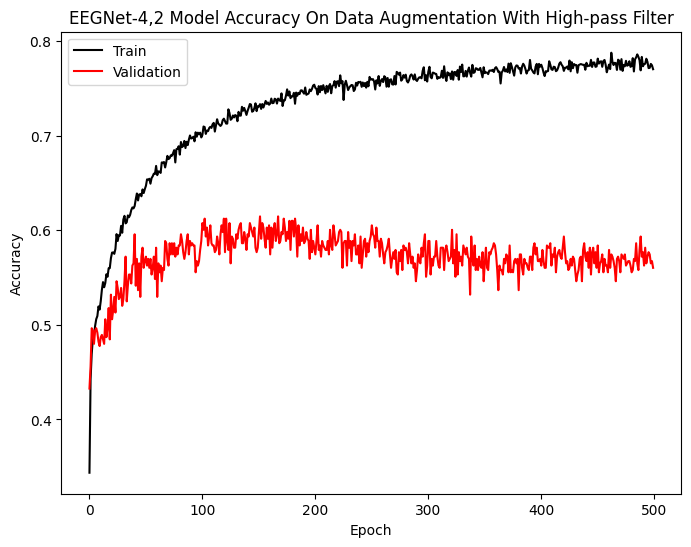

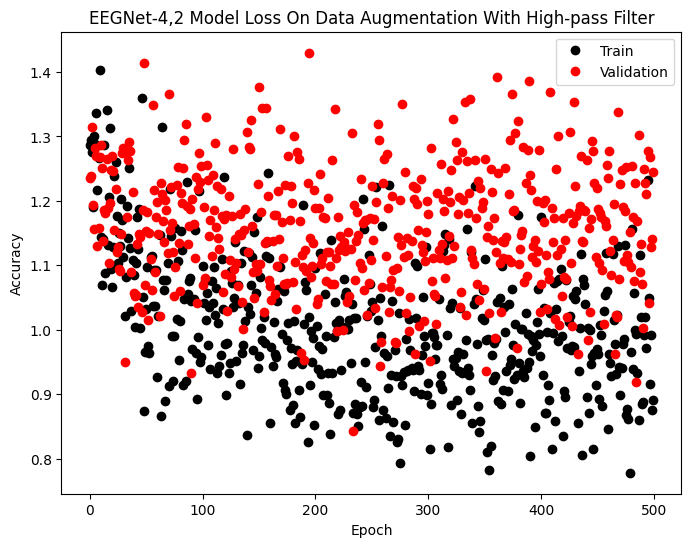

In [ ]:
plt.plot(torch.tensor(EEGNet_hp_history['train_acc']).cpu(), label='Train', color='black')
plt.plot(torch.tensor(EEGNet_hp_history['val_acc']).cpu(), label='Validation', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EEGNet-4,2 Model Accuracy On Data Augmentation With High-pass Filter')
plt.savefig('EEGNet-4,2 Model Accuracy On Data Augmentation With High-pass Filter.png', bbox_inches='tight', dpi=150)
plt.show()

plt.plot(torch.tensor(EEGNet_hp_history['train_loss']),'o', label='Train', color='black')
plt.plot(torch.tensor(EEGNet_hp_history['val_loss']),'o', label='Validation', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EEGNet-4,2 Model Loss On Data Augmentation With High-pass Filter')
plt.savefig('EEGNet-4,2 Model Loss On Data Augmentation With High-pass Filter.png', bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
tester(model_hp, test_hp_dataset)

Test acc: 0.589


### Part 5: Band-pass Filter
#### 5.1 Perform band-pass filter

In [ ]:
# Randomly split training-validation dataset
inx_valid = np.random.choice(2115, 423, replace=False)
inx_train = np.array(list(set(range(2115)).difference(set(inx_valid))))

(x_train, x_valid) = X_train_valid[inx_train], X_train_valid[inx_valid]
(y_train, y_valid) = y_train_valid[inx_train], y_train_valid[inx_valid]

print('Shape of training set after splitting:',x_train.shape)
print('Shape of validation set after splitting:',x_valid.shape)
print('Shape of training labels after splitting:',y_train.shape)
print('Shape of validation labels after splitting:',y_valid.shape,'\n')

# Preprocessing the dataset, may need to reload data at top
# pass only training data to train prep, val and test data to test prep
x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(X_test), test_data_prep(x_valid)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape,'\n')

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
x_valid = x_valid.reshape(x_valid.shape[0], 1, x_valid.shape[1], x_valid.shape[2])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape,'\n')

x_train_bp = band_pass(x_train)
x_valid_bp = band_pass(x_valid)
x_test_bp = band_pass(x_test)

print('Shape of training set after low pass filter:',x_train_bp.shape)
print('Shape of validation set after low pass filter:',x_valid_bp.shape)
print('Shape of test set after low pass filter:',x_test_bp.shape)

# Convert to Tensor
train_bp_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_hp), torch.from_numpy(y_train))
valid_bp_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_valid_hp), torch.from_numpy(y_valid))
test_bp_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_hp), torch.from_numpy(y_test))

Shape of training set after splitting: (1692, 22, 1000)
Shape of validation set after splitting: (423, 22, 1000)
Shape of training labels after splitting: (1692,)
Shape of validation labels after splitting: (423,) 

Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: (6768, 22, 400)
Shape of validation set: (423, 22, 400)
Shape of training labels: (6768,)
Shape of validation labels: (423,) 

Shape of training set after adding width info: (6768, 1, 22, 400)
Shape of validation set after adding width info: (423, 1, 22, 400)
Shape of test set after adding width info: (443, 1, 22, 400) 

Shape of training set afte

### 5.2 Train-Validate-Test model with band-pass filter

In [ ]:
# Train and validate model
model = EEGNet(x_train_bp.shape[-1]).to(device)
EEGNet_bp_history, model_bp = trainer(model,train_bp_dataset,valid_bp_dataset, epochs=epochs)

Epoch 499, train acc = 0.6715, val acc = 0.3073: 100%|██████████| 500/500 [05:28<00:00,  1.52it/s]

Best train Accuracy: 0.681
Best validation Accuracy: 0.326
Best train Loss: 0.891
Best validation Loss: 1.189


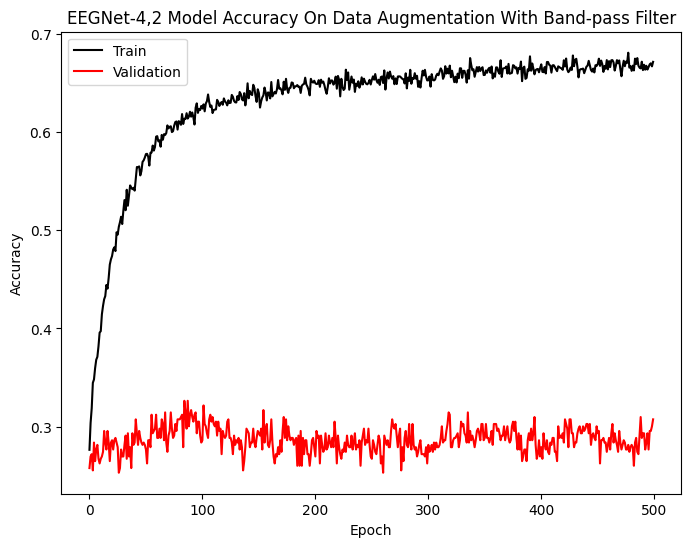

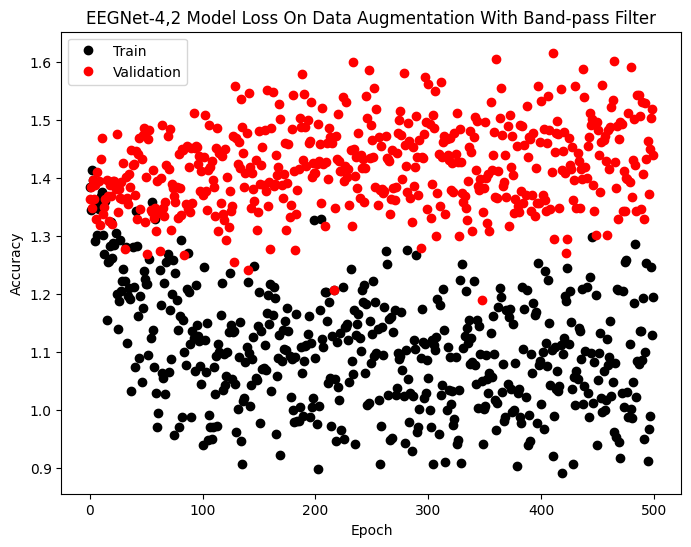

In [ ]:
plt.plot(torch.tensor(EEGNet_bp_history['train_acc']).cpu(), label='Train', color='black')
plt.plot(torch.tensor(EEGNet_bp_history['val_acc']).cpu(), label='Validation', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EEGNet-4,2 Model Accuracy On Data Augmentation With Band-pass Filter')
plt.savefig('EEGNet-4,2 Model Accuracy On Data Augmentation With Band-pass Filter.png', bbox_inches='tight', dpi=150)
plt.show()

plt.plot(torch.tensor(EEGNet_bp_history['train_loss']),'o', label='Train', color='black')
plt.plot(torch.tensor(EEGNet_bp_history['val_loss']),'o', label='Validation', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EEGNet-4,2 Model Loss On Data Augmentation With Band-pass Filter')
plt.savefig('EEGNet-4,2 Model Loss On Data Augmentation With Band-pass Filter.png', bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
tester(model_bp, test_bp_dataset)

Test acc: 0.239
